In [93]:
%load_ext abjad.ext.ipython
import abjad
from abjad import graphtools
import random

The abjad.ext.ipython extension is already loaded. To reload it, use:
  %reload_ext abjad.ext.ipython


# A Bottom-up Approach to Complex Rhythms

You might want to build some rhythms from scratch at some point. You really just need the `Duration` and `Tuplet` classes to do this.

### Durations

When you want to work with arbitrary durations of metered time, use the `Duration` class to describe temporal divisions:

In [94]:
numerators = range(1, 16)
denominators = [2**x for x in range(5)]
durations = []
for x in range(10):
    numerator = random.choice(numerators)
    denominator = random.choice(denominators)
    duration = abjad.Duration(numerator, denominator)
    durations.append(duration)
print(durations)

[Duration(15, 8), Duration(7, 1), Duration(1, 16), Duration(13, 2), Duration(13, 16), Duration(11, 2), Duration(1, 4), Duration(3, 2), Duration(15, 8), Duration(13, 2)]


Keep in mind that not all durations can be assigned to a leaf's duration -- this throws an `AssignabilityError`, because a single leaf can't have a duration of five quarter notes:

In [95]:
rest = abjad.Rest(abjad.Duration(5,4))

AssignabilityError: not assignable duration: Duration(5, 4).

But there are utility functions that will generate multiple leaves for you:

Fortunately, Abjad comes with a `LeafMaker` class that will help us out with problems like this:

In [96]:
maker = abjad.LeafMaker()
pitches = [None] # if pitches is None, you get rests
durations = [abjad.Duration(13, 16)]
rests = maker(pitches, durations)
staff = abjad.Staff(rests)
abjad.show(staff)

For pitched examples of `LeafMaker`, see its [documentation](http://abjad.mbrsi.org/api/tools/scoretools/LeafMaker.html#abjad.tools.scoretools.LeafMaker) -- and let's continue our discussion of rhythm and meter.

### Tuplets

Use the `Tuplet` class to make rhythmic tuplets (that is, any non-binary division of time into equally spaced events). The Tuplet class provides an interface for working with complex rhythms in a bottom-up way -- use a `Multiplier` to specify the prolation ratio, and then give a list of leaves:

In [97]:
tuplet = abjad.Tuplet(abjad.Multiplier(2, 3), "c'8 d'8 e'8")

In [98]:
abjad.show(tuplet)

You can also pack existing leaves into a Tuplet instance.

In [99]:
leaves = [abjad.Note("fs'8"), abjad.Note("g'8"), abjad.Rest('r8')]

In [100]:
tuplet = abjad.Tuplet(abjad.Multiplier(2, 3), leaves)

In [101]:
abjad.show(tuplet)

`Tuplet`s are containers, and binary leaves that neighbor a tuplet are siblings of the tuplet container itself, but not of the leaves inside the tuplet:

In [103]:
staff = abjad.Staff()
leaves = [abjad.Note("cs''8"), tuplet, abjad.Note("af'8")]
staff.extend(leaves)
abjad.f(staff)
abjad.graph(staff)

\new Staff {
    cs''8
    \times 2/3 {
        fs'8
        g'8
        r8
    }
    af'8
}


NameError: name 'graphtools' is not defined

## Understanding Augmentation and Diminution

Remember that any tuplet can be represented as an augmentation or a diminution relative to the written notes' default values. Our example tuplet's multiplier of (2,3) for three eighth notes means that each written eighth note lasts for 2/3rds its written value. Because the original durations have been reduced, this is a diminution:

In [104]:
tuplet.is_diminution

True

A tuplet with a multiplier greater than 1, on the other hand, would be an augmentation:

In [106]:
tuplet = abjad.Tuplet((4,3), "fs'16 g'16 r16")

In [107]:
abjad.show(tuplet)


This last tuplet is an augmentation in which each of the written sixteenth notes lasts for 4/3rds of its written duration. The sounding result would be identical, and these are just two ways of writing the same thing, the former of which happens to be conventional.

Remember that object-oriented programming gives us objects with characteristics and behaviors. We can use the dot-chaining syntax to read and write the tuplet's multiplier attribute:

In [109]:
tuplet = abjad.Tuplet(abjad.Multiplier(2, 3), "fs'8 g' r8")

In [13]:
tuplet.multiplier

Multiplier(2, 3)

In [14]:
tuplet.multiplier = Multiplier(4, 5)

In [15]:
tuplet

Tuplet(Multiplier(4, 5), "fs'8 g'8 r8")

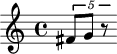

In [16]:
show(tuplet)

## Adding Leaves

You can also build up tuplets by adding leaves to them, one or several a time. The append method adds leaves to the end of a tuplet (and to any Python list), one leaf at a time:

In [17]:
tuplet.append(Note("e'4."))

In [110]:
abjad.show(tuplet)

...or using a LilyPond string:

In [111]:
tuplet.append("bf8")

In [112]:
abjad.show(tuplet)

Likewise, the extend method adds two or more leaves at a time:

In [113]:
notes = [abjad.Note("fs'32"), abjad.Note("e'32"), abjad.Note("d'32"), abjad.Rest((1, 32))]

In [114]:
tuplet.extend(notes)

In [115]:
abjad.show(tuplet)

And you can use a LilyPond string with extend, too:

In [116]:
tuplet.extend("gs'8 a8")

In [118]:
abjad.show(tuplet)

## Removing Leaves

You can remove tuplet components by reference using the remove method:

In [119]:
tuplet.remove(tuplet[3])

In [120]:
abjad.show(tuplet)

If you want to remove a component by index and then keep it to do something else with it, use the pop method instead of remove:

In [122]:
popped = tuplet.pop(2)
print(popped)

fs'32


In [123]:
abjad.show(tuplet)

## Indexing Leaves

Tuplets support indexing, if you'd like to do something to the nth component of a tuplet:

In [124]:
tuplet[1]

Note("g'8")

If you've added an existing list to a tuplet's components, and you'd like to see where a component of that list is in the tuplet, you can use the tuplet's index method - in our case, we'll use our notes list from above:

In [125]:
notes

[Note("fs'32"), Note("e'32"), Note("d'32"), Rest('r32')]

In [126]:
notes[1]

Note("e'32")

In [127]:
tuplet.index(notes[1])

2

The second item in our notes list is the seventh component in our tuplet.

## Making Tuplets from Durations and Ratios

The above treats tuplets as prolations of written note durations scaled by a multiplier, but that's not always how composers think about tuplets. A lot of the time, you'll want to think of tuplets as the arbitrary division of a temporal unit. You can make tuplets by dividing arbitrary durations according to internal durational relationships: you can construct a tuplet from a duration and a ratio, where the ratio is a list of integers, the sum of which determines the number of equally spaced pulses within the duration.

In [155]:
tuplet = abjad.Tuplet.from_duration_and_ratio((1,4), [1,3,1])

In [156]:
staff = abjad.Staff([tuplet], context_name='RhythmicStaff')

In [157]:
abjad.show(staff)

This might not seem like much, but we can write functions that use these kinds of basic functionalities to do more complicated things, like we'll do in this next example, taken from a real score:

# Brian Ferneyhough - Unsichtbare Farben 

Mikhial Malt analyzes the rhythmic materials of Ferneyhough’s solo violin composition, Unsichtbare Farben, in The OM Composer’s Book 2.

Malt explains that Ferneyhough used OpenMusic to create an “exhaustive catalogue of rhythmic cells” such that:

Each cell consists of the same duration divided into two pulses related by a durational proportion ranging from 1:1 to 1:11.

The second pulse is then subdivided successively into 1, 2, 3, 4, 5 and 6 equal parts.

Let’s recreate Malt’s results in Abjad.

## The Proportions 

We use a list comprehension to describe a list of (1,n) tuples, each of which will describe the durational proportion between a cell's first and second pulse:

In [158]:
proportions = [(1, n) for n in range(1, 11 + 1)]

In [159]:
proportions

[(1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11)]

## The Transforms

Next we’ll show how to divide a quarter note into various ratios, and then divide the final logical tie of the resulting tuplet into yet another ratio:

In [160]:
def make_nested_tuplet(
    tuplet_duration,
    outer_tuplet_proportions,
    inner_tuplet_subdivision_count,
    ):
    r'''Makes nested tuplet.
    '''

    outer_tuplet = abjad.Tuplet.from_duration_and_ratio(
        tuplet_duration, outer_tuplet_proportions)
    inner_tuplet_proportions = inner_tuplet_subdivision_count * [1]
    last_leaf = next(abjad.iterate(outer_tuplet).by_leaf())
    right_logical_tie = abjad.inspect(last_leaf).get_logical_tie()
    right_logical_tie.to_tuplet(inner_tuplet_proportions)
    return outer_tuplet

And of course it's easier to see what this function does with an example of use:

In [161]:
tuplet = make_nested_tuplet(abjad.Duration(1, 4), (1, 1), 5)

In [162]:
staff = abjad.Staff([tuplet], context_name='RhythmicStaff')

In [163]:
abjad.show(staff)

We see that a duration of a quarter note (the first argument) has been divided into two pulses with a durational proportion of 1:1 (second argument), the second pulse of which has then been divided into five equally spaced parts (the third argument). Try changing the arguments and see what happens.

In [164]:
tuplet = make_nested_tuplet(abjad.Duration(1, 4), (2, 1), 5)

In [165]:
staff = abjad.Staff([tuplet], context_name='RhythmicStaff')

In [166]:
abjad.show(staff)

In [167]:
tuplet = make_nested_tuplet(abjad.Duration(1, 4), (3, 1), 5)

In [168]:
staff = abjad.Staff([tuplet], context_name='RhythmicStaff')

In [169]:
abjad.show(staff)

### Logical Ties Solve the Problem of Five

A logical tie is a selection of notes or chords connected by ties. It lets us talk about a notated rhythm of 5/16, for example, which can not be expressed with only a single leaf.

Note how we can divide a tuplet whose outer proportions are 3/5, where the second logical tie requires two notes to express the 5/16 duration:

In [170]:
outer_tuplet = abjad.Tuplet.from_duration_and_ratio(abjad.Duration(1, 4), (3, 5))

In [171]:
staff = abjad.Staff([outer_tuplet], context_name='RhythmicStaff')

In [172]:
abjad.show(staff)

In [173]:
subdivided_tuplet = make_nested_tuplet(abjad.Duration(1, 4), (3, 5), 3)

In [174]:
staff = abjad.Staff([subdivided_tuplet], context_name='RhythmicStaff')

In [175]:
abjad.show(staff)

Do you see which objects and methods in our make_nested_tuplet function convert a logical tie into a tuplet?

## The Rhythms

Now that we know how to make the basic building block, let’s make a lot of tuplets all at once.

We’ll set the duration of each tuplet equal to a quarter note:

In [176]:
duration = abjad.Fraction(1,4)

Reusing our make_nested_tuplet function, we make one row of rhythms, with the last logical tie increasingly subdivided:

In [177]:
def make_row_of_nested_tuplets(
    tuplet_duration,
    outer_tuplet_proportions,
    column_count,
    ):
    r'''Makes row of nested tuplets.
    '''

    assert 0 < column_count
    row_of_nested_tuplets = []
    for n in range(column_count):
        inner_tuplet_subdivision_count = n + 1
        nested_tuplet = make_nested_tuplet(
            tuplet_duration,
            outer_tuplet_proportions,
            inner_tuplet_subdivision_count,
            )
        row_of_nested_tuplets.append(nested_tuplet)
    return row_of_nested_tuplets

In [178]:
tuplets = make_row_of_nested_tuplets(duration, (2, 1), 6)

In [180]:
staff = abjad.Staff(tuplets, context_name='RhythmicStaff')

In [181]:
abjad.show(staff)

If we can make one single row of rhythms, we can make many rows of rhythms. We reuse this last function to make another function:

In [182]:
def make_rows_of_nested_tuplets(tuplet_duration, row_count, column_count):
    r'''Makes rows of nested tuplets.
    '''

    assert 0 < row_count
    rows_of_nested_tuplets = []
    for n in range(row_count):
        outer_tuplet_proportions = (1, n + 1)
        row_of_nested_tuplets = make_row_of_nested_tuplets(
            tuplet_duration, outer_tuplet_proportions, column_count)
        rows_of_nested_tuplets.append(row_of_nested_tuplets)
    return rows_of_nested_tuplets

In [183]:
score = abjad.Score()

In [184]:
for tuplet_row in make_rows_of_nested_tuplets(duration, 4, 6):
    score.append(abjad.Staff(tuplet_row, context_name='RhythmicStaff'))

In [185]:
abjad.show(score)

This example illustrates how simpler bottom-up rhythmic construction might be abstracted and encapsulated in a reconfigurable way to explore the potential of a rhythmic idea.